In [132]:
# baseline cnn model
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.optimizers import SGD
from os import listdir
import os, sys
from IPython.display import display
from IPython.display import Image as _Imgdis
from PIL import Image
import numpy as np
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import load_model
from keras import backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.applications.vgg16 import preprocess_input

In [133]:
def extract_features(filename):
    # Loading and resizing image
    image = load_img(filename, target_size=(400,500))
    # Convert the image pixels to a numpy array
    image = img_to_array(image, "channels_first")
    image_to_show = array_to_img(image, "channels_first")
    imgplot = plt.imshow(image_to_show)
    # Reshape data for the model
    image = image.reshape((image.shape[0], image.shape[1], image.shape[2]))
    # Prepare the image for the CNN Model model
    image_to_show = array_to_img(image, "channels_first")
    imgplot = plt.imshow(image_to_show)
    plt.show()
    image = preprocess_input(image)
    image_to_show = array_to_img(image, "channels_first")
    imgplot = plt.imshow(image_to_show)
    plt.show()
    return image

In [134]:
# load train and test dataset
def load_dataset(pathImages, pathLabeled):
    onlyfiles = [f for f in os.listdir(pathImages) if os.path.isfile(os.path.join(pathImages, f))]
    
    train_files = []
    y_train = []
    i=0
    for _file in onlyfiles:
        train_files.append(_file)

    image_width = 1000
    image_height = 800
    ratio = 2

    image_width = int(image_width / ratio)
    image_height = int(image_height / ratio)

    channels = 3
    nb_classes = 1

    dataset = np.ndarray(shape=(len(train_files), channels, image_height, image_width),
                         dtype=np.float32)
    i = 0
    for _file in train_files:
        dataset[i] = extract_features(pathImages + "/" + _file)
        i += 1
#         if i % 100 == 0:
#             print("%d images to array" % i)
    print("All images to array!")

    z_train, y_train = np.loadtxt(pathLabeled, delimiter=' | ', unpack = True)
    
    from sklearn.model_selection import train_test_split

    #Splitting 
    X_train, X_test, y_train, y_test = train_test_split(dataset, y_train, test_size=0.4, random_state=0)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=0)
    print("Train set size: {0}, Val set size: {1}, Test set size: {2}".format(len(X_train), len(X_val), len(X_test)))
    
    return X_train, y_train, X_test, y_test

In [158]:
# define cnn model
def define_model():
        
    model = Sequential()
    
    model.add(Conv2D(199, (3, 3), activation='relu', input_shape=(3, 400, 500)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same', data_format=None))
    model.add(Dropout(0.25))
    model.add(Conv2D(199, kernel_size=(-1, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    
    model.add(Dense(2, activation='sigmoid'))
#   compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [136]:
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

In [137]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, batch_size=32, epochs=10, verbose=0, validation_data=(testX, testY))
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories

In [138]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		pyplot.subplot(2, 1, 1)
		pyplot.title('Cross Entropy Loss')
		pyplot.plot(histories[i].history['loss'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		pyplot.subplot(2, 1, 2)
		pyplot.title('Classification Accuracy')
		pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	pyplot.show()

In [139]:
# summarize model performance
def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	# box and whisker plots of results
	pyplot.boxplot(scores)
	pyplot.show()

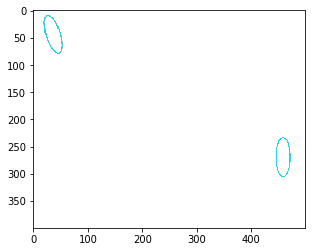

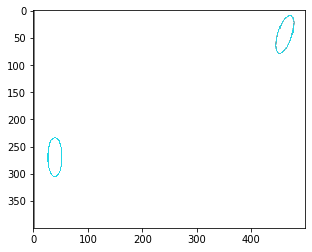

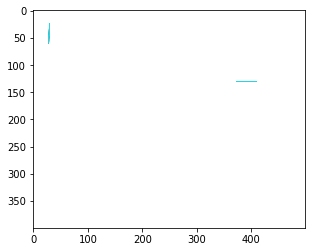

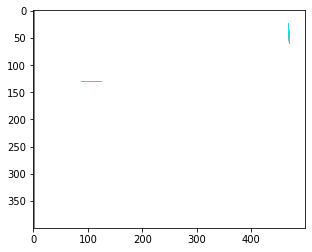

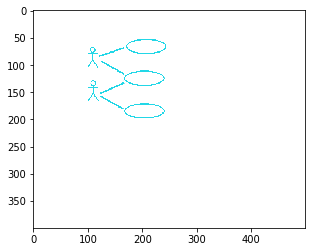

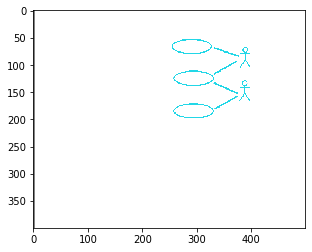

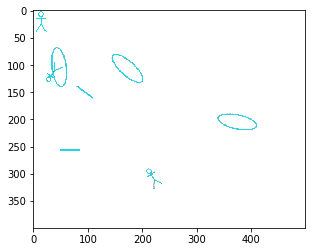

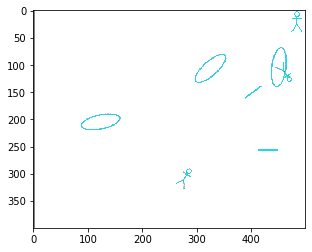

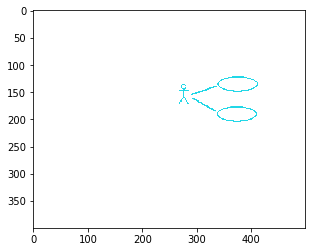

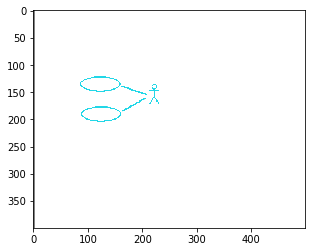

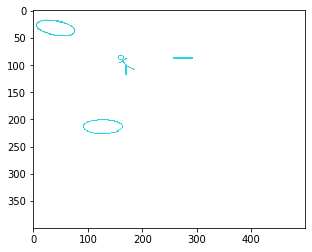

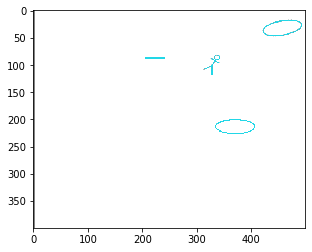

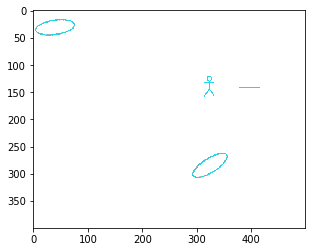

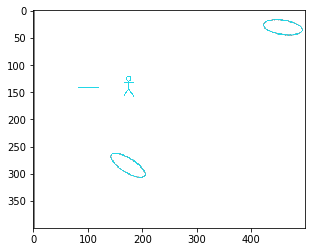

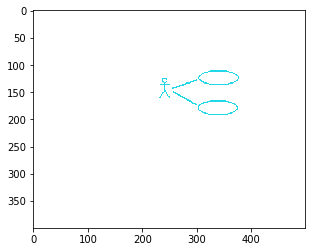

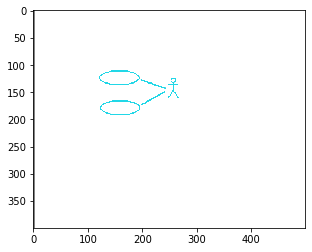

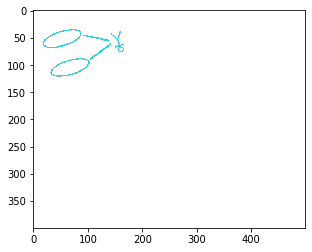

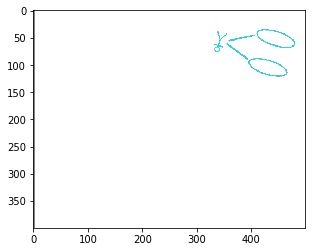

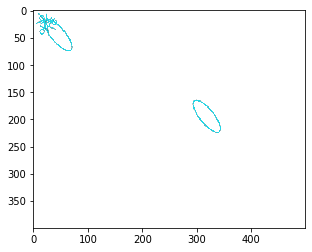

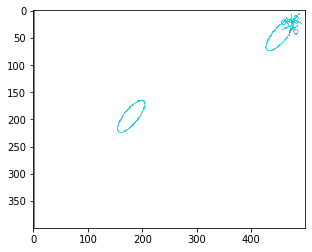

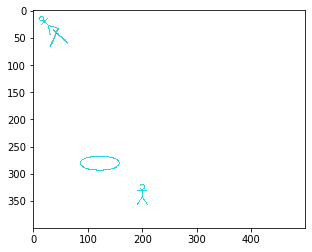

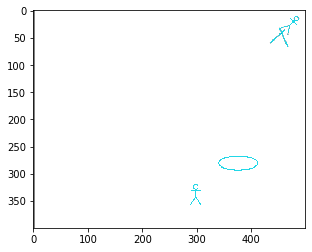

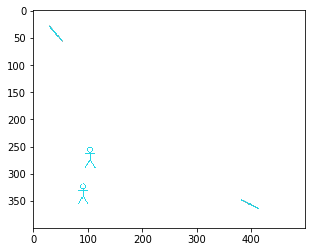

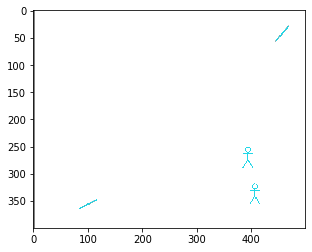

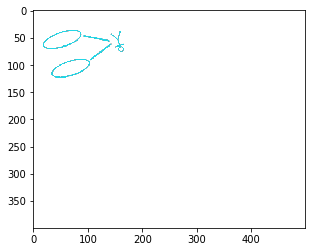

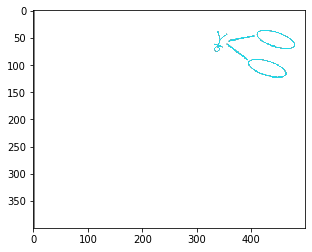

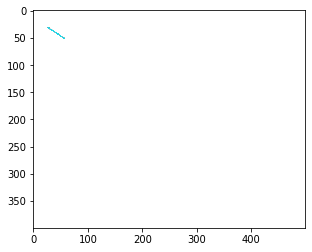

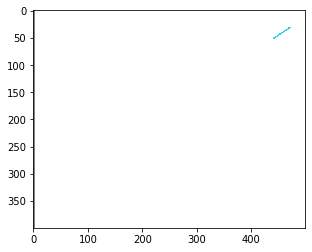

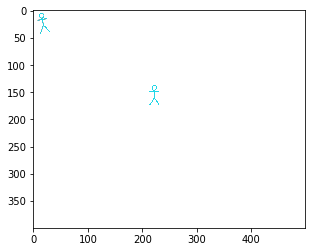

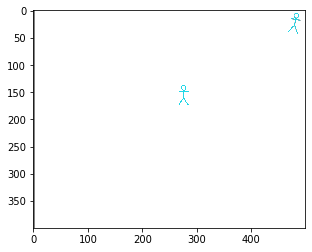

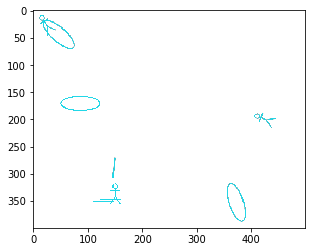

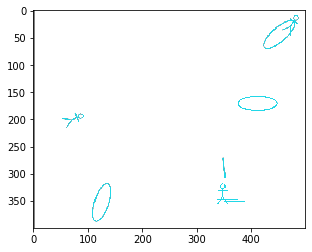

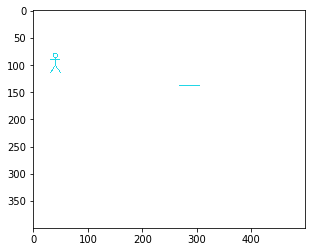

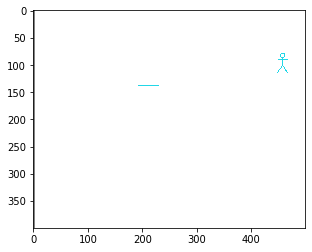

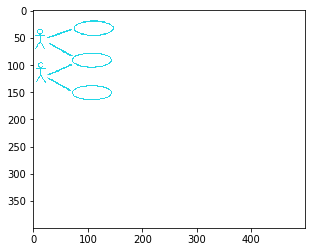

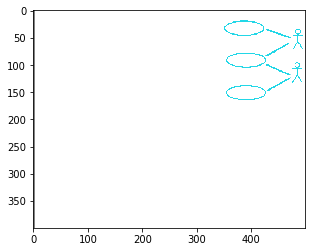

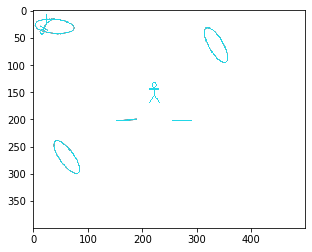

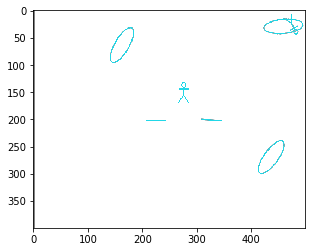

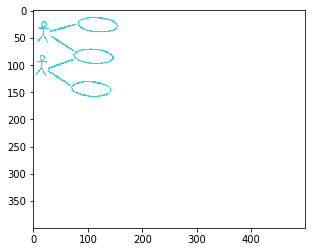

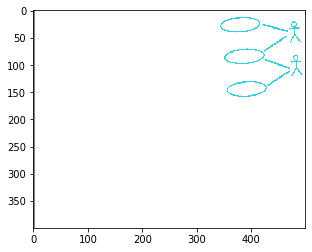

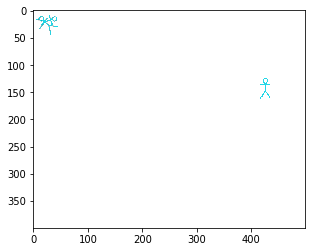

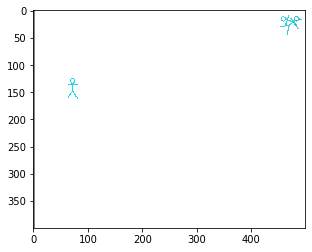

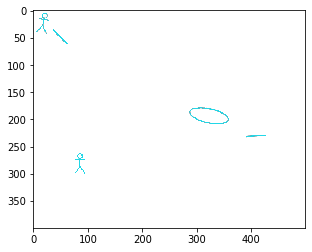

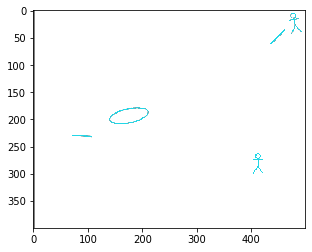

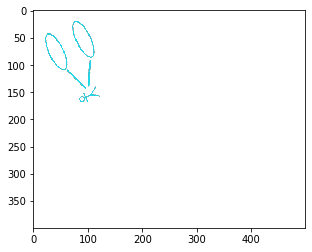

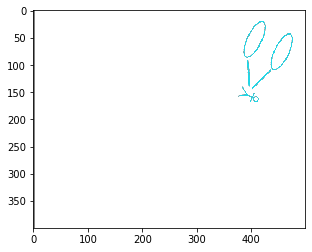

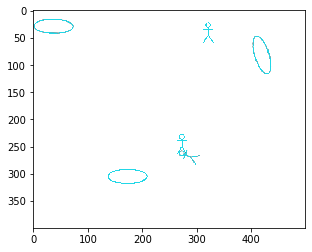

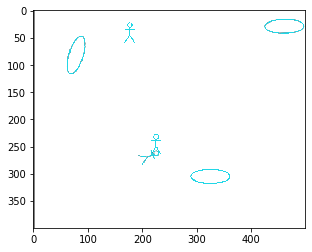

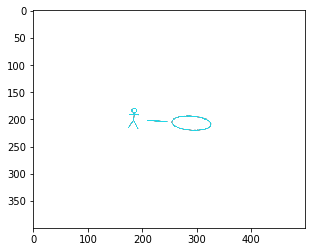

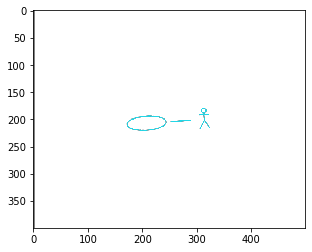

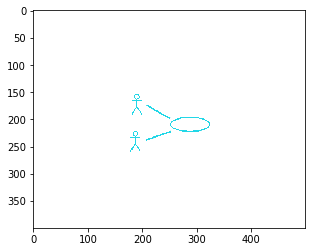

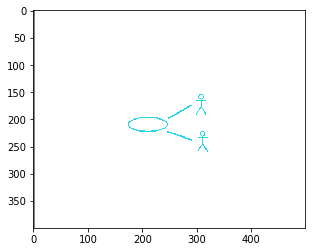

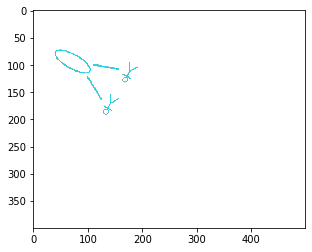

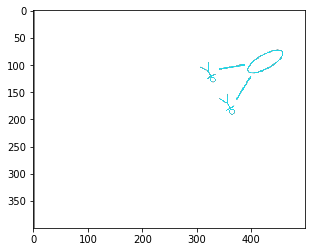

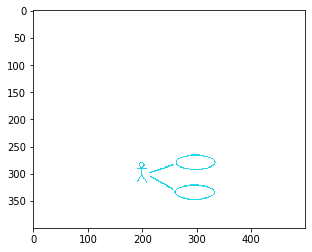

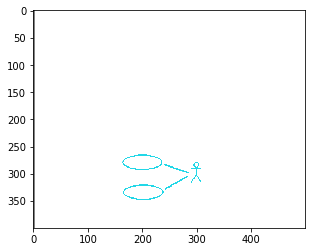

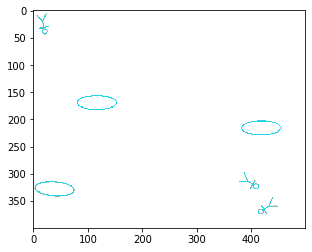

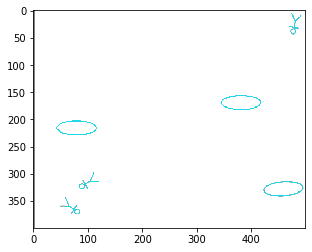

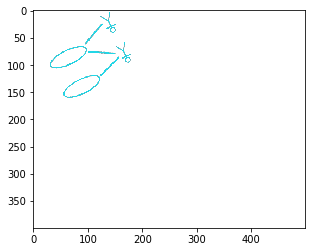

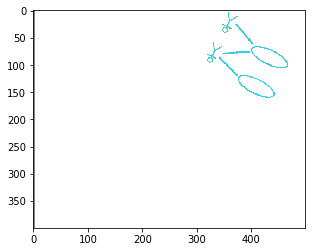

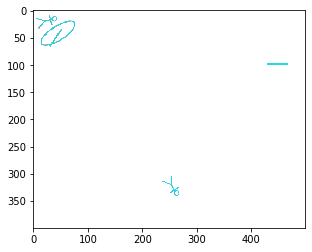

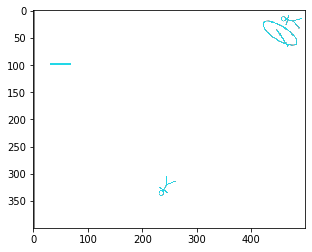

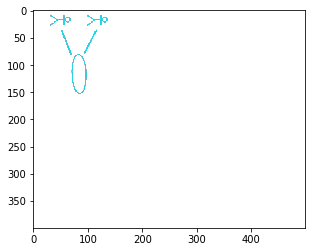

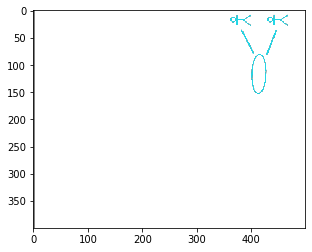

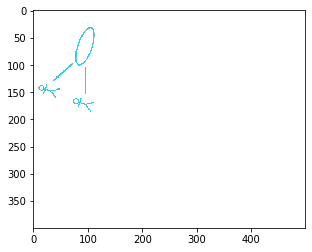

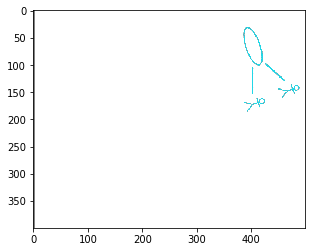

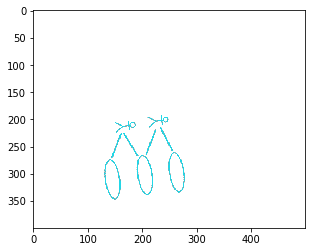

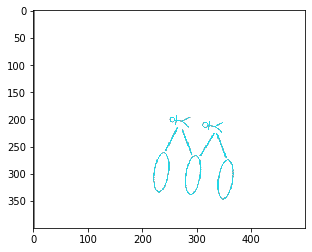

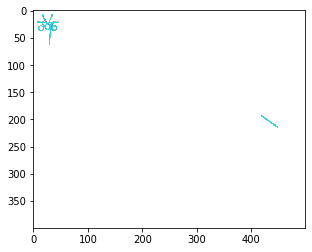

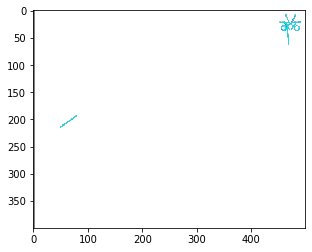

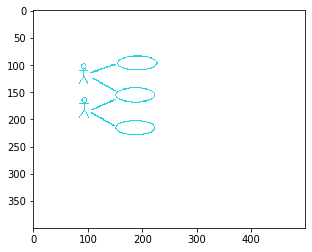

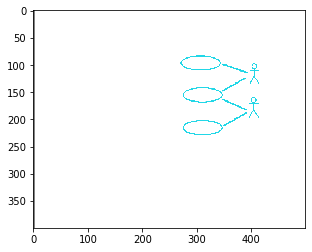

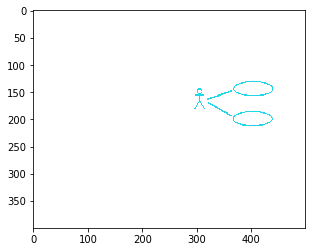

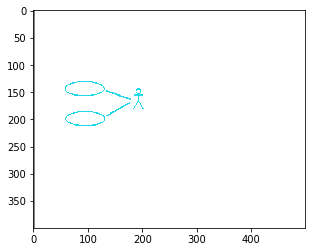

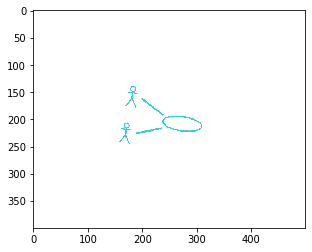

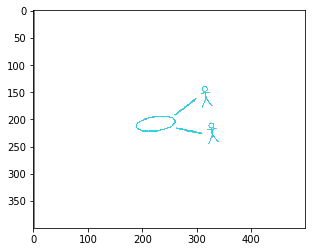

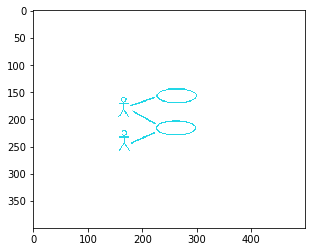

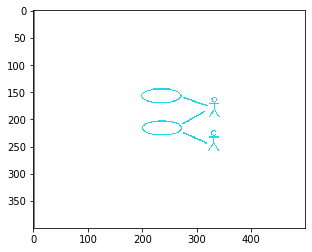

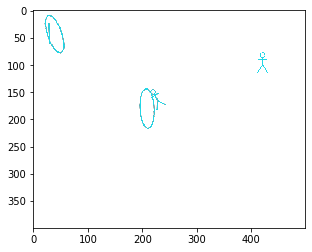

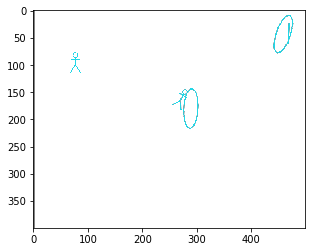

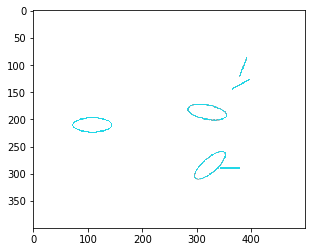

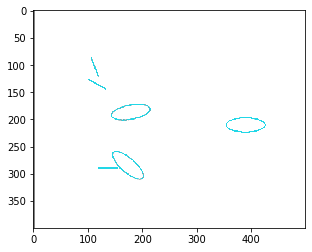

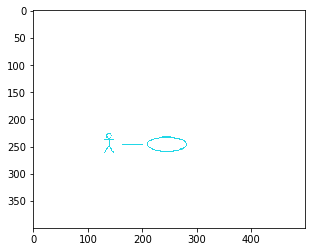

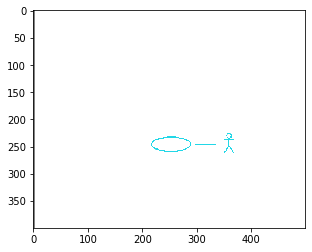

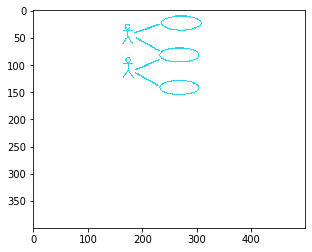

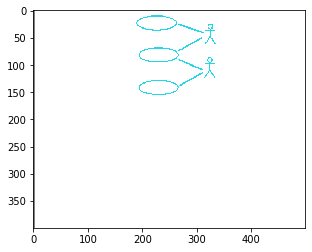

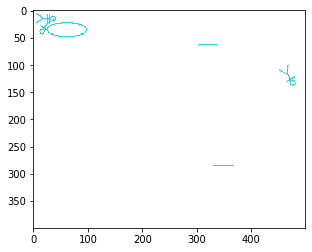

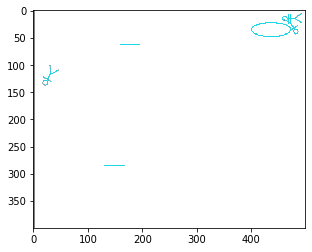

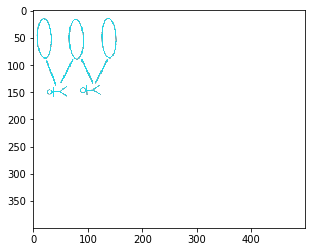

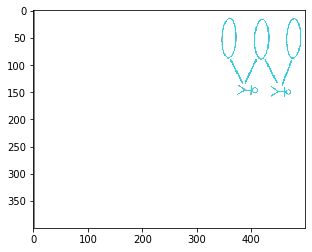

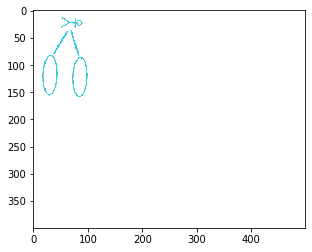

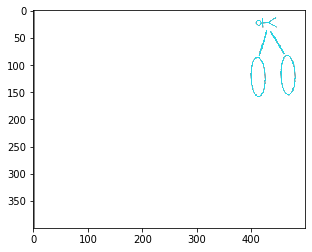

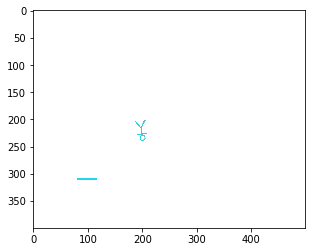

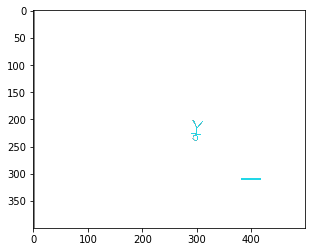

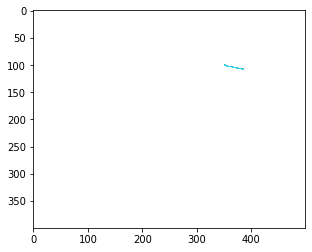

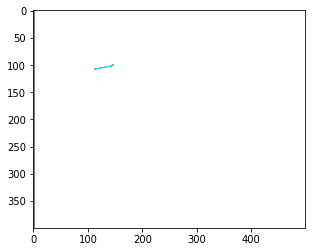

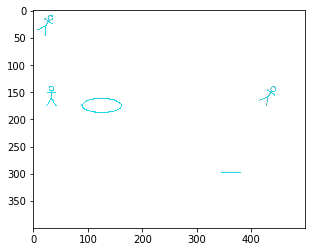

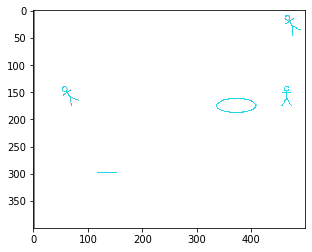

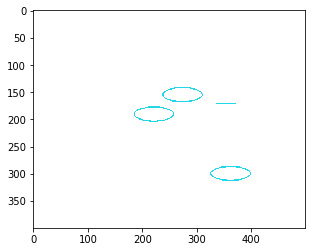

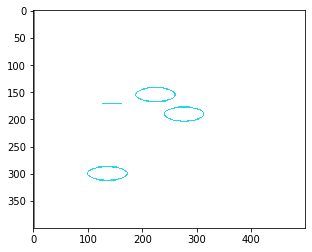

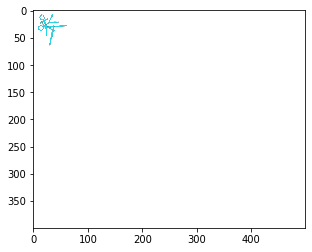

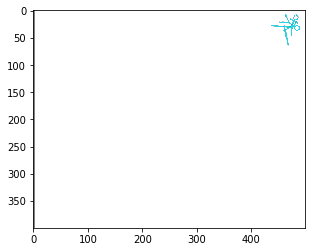

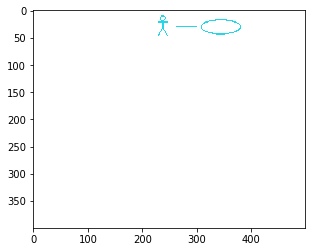

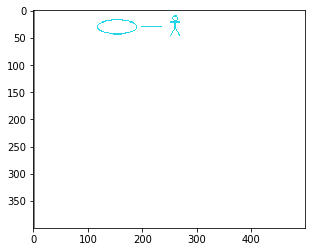

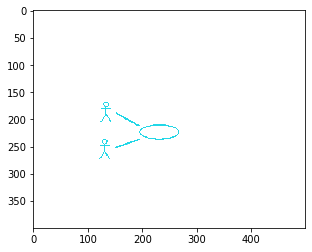

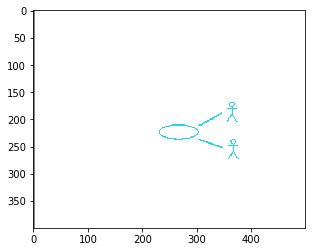

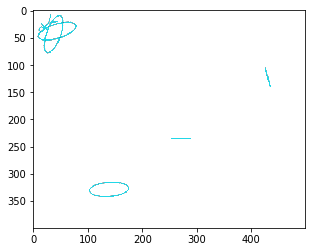

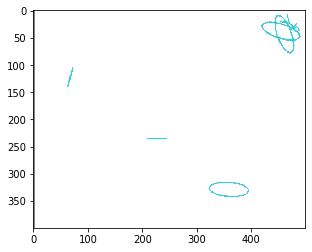

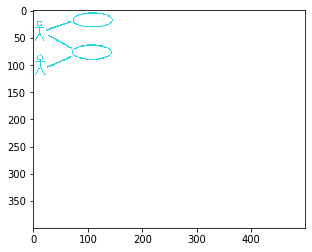

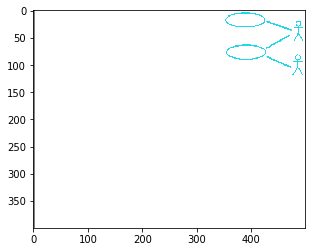

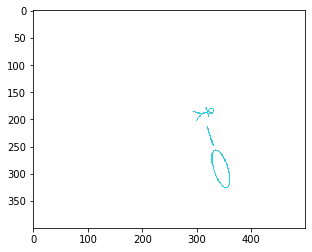

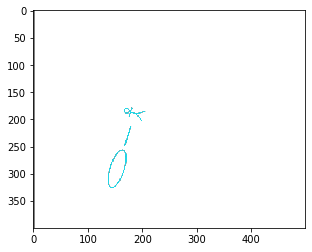

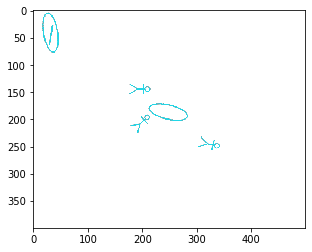

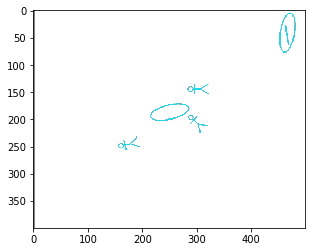

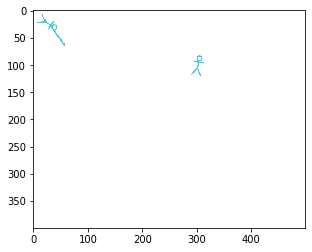

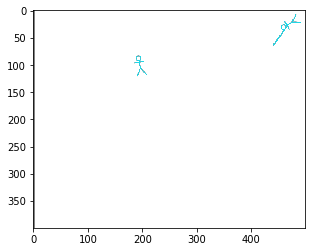

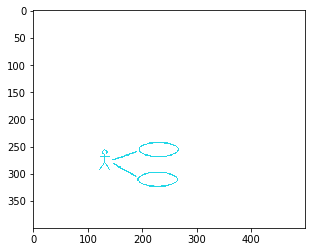

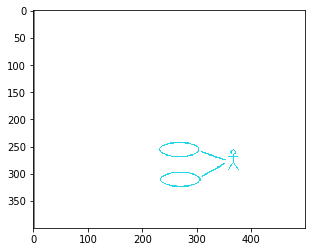

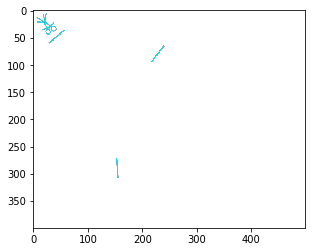

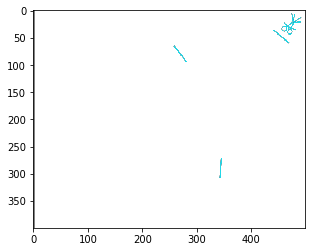

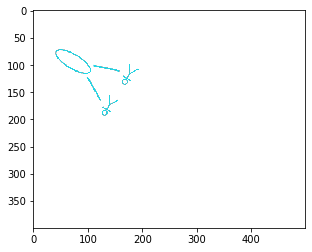

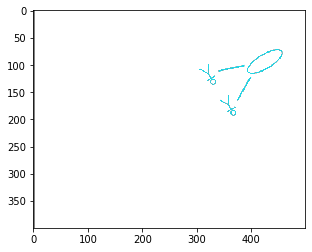

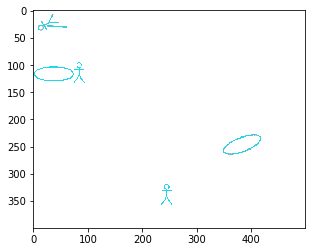

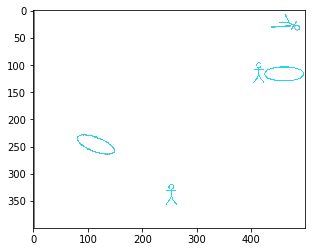

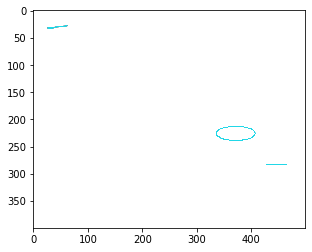

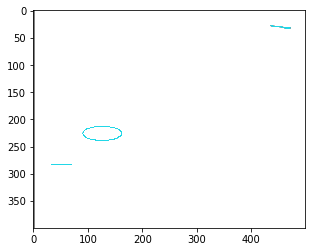

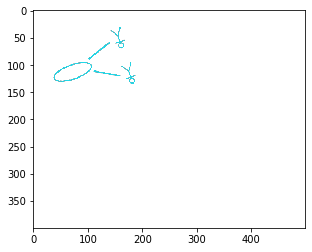

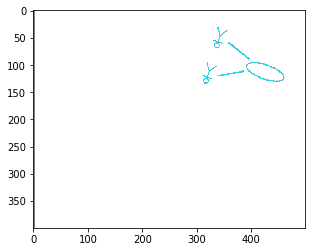

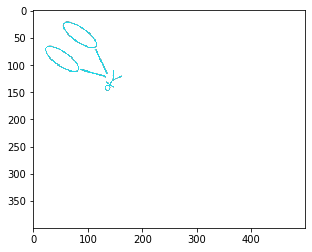

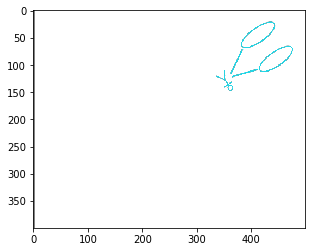

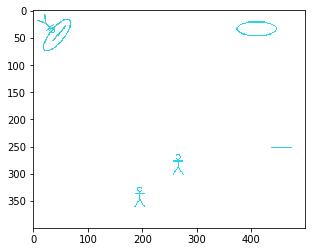

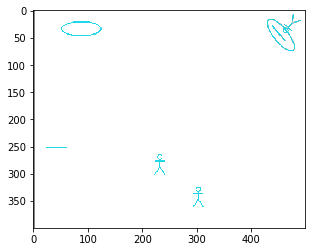

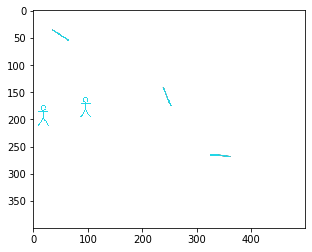

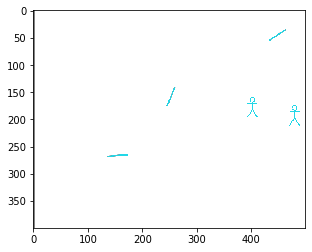

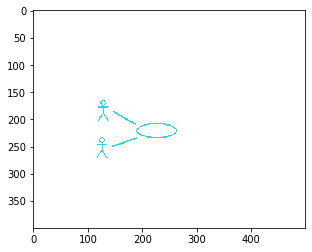

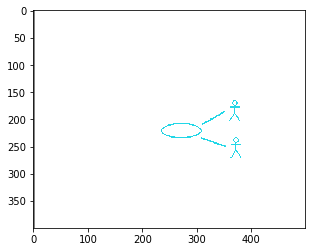

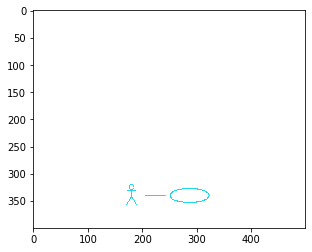

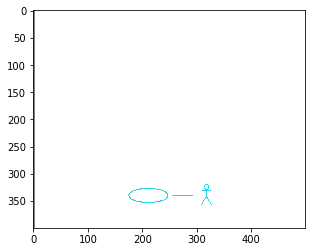

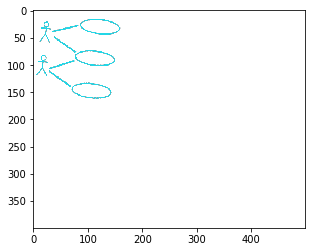

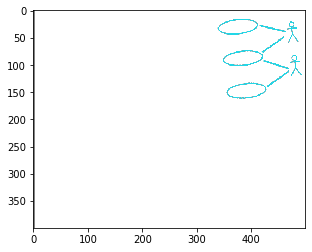

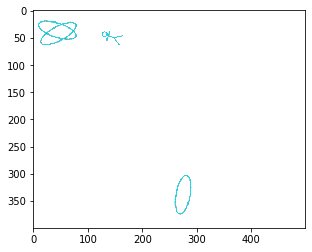

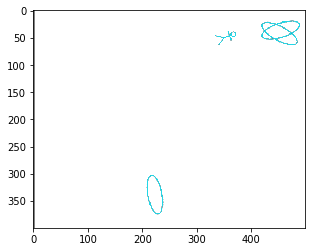

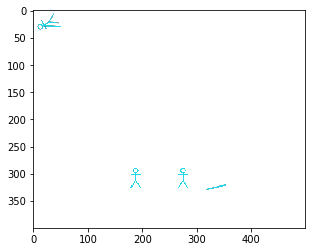

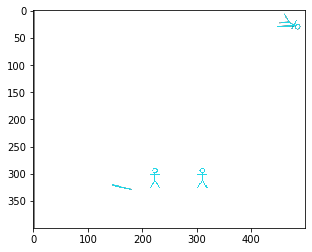

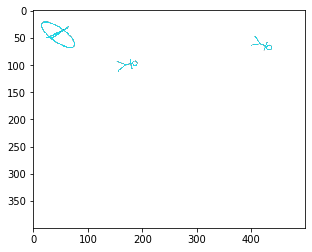

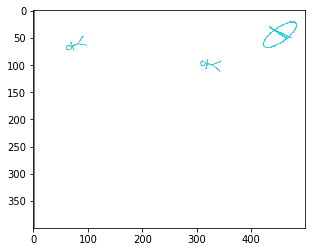

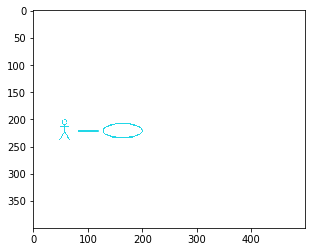

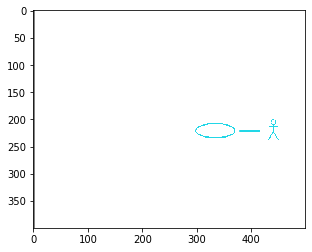

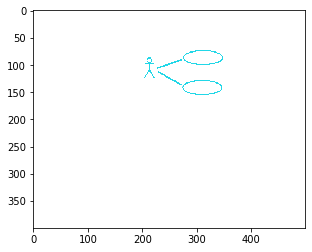

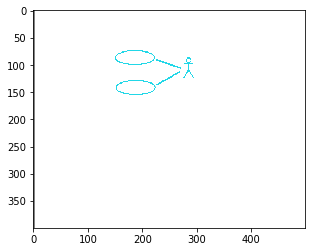

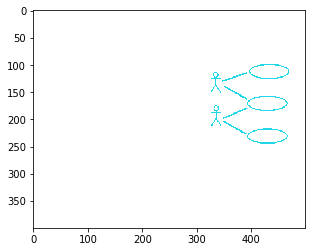

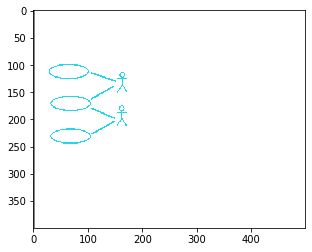

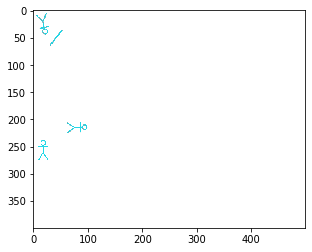

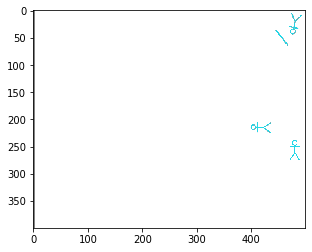

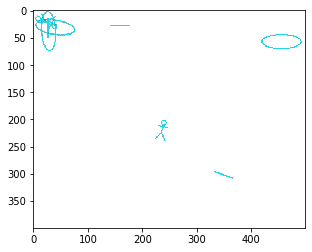

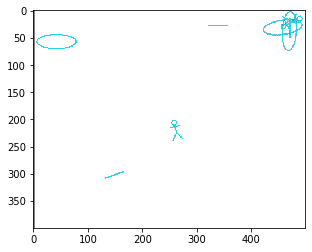

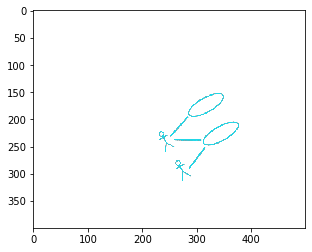

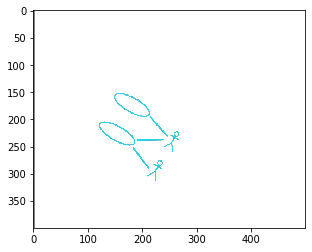

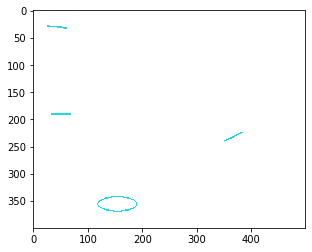

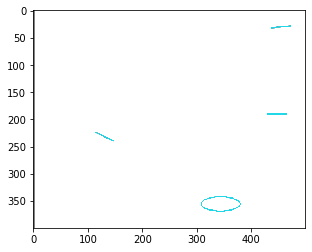

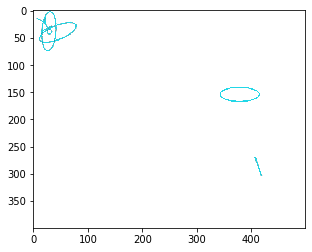

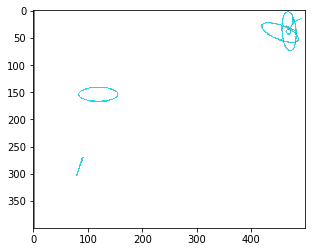

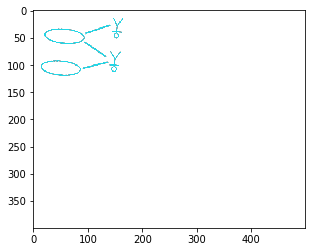

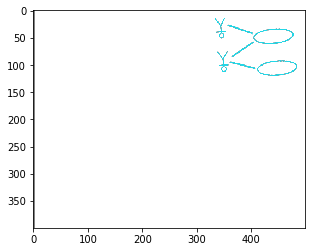

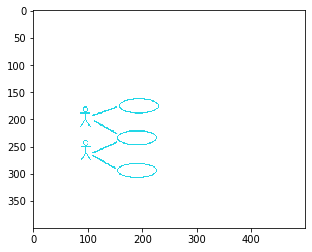

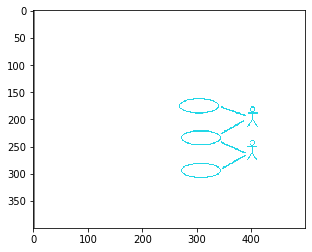

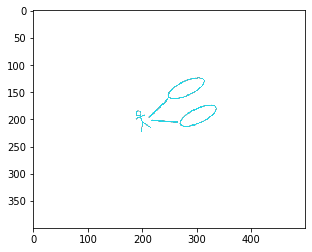

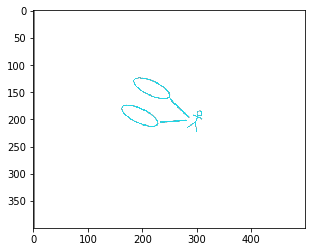

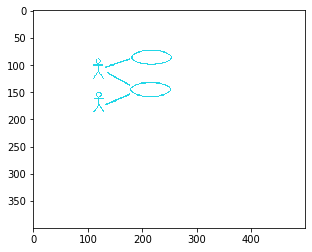

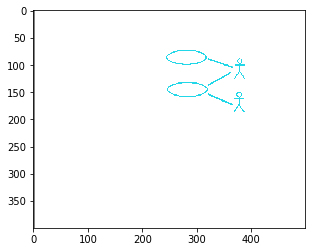

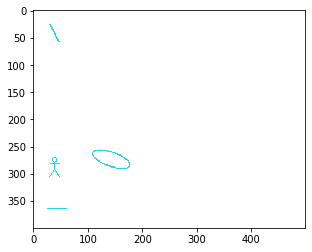

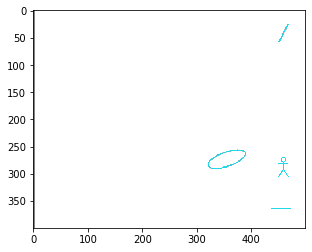

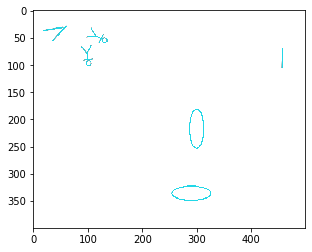

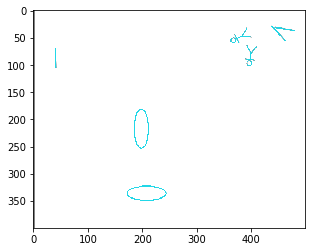

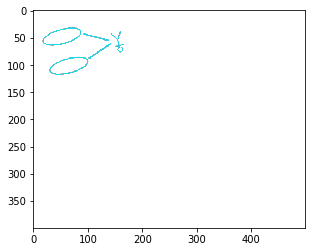

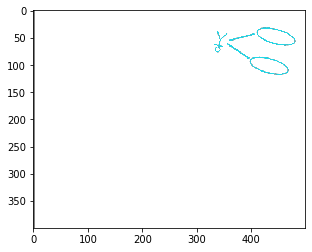

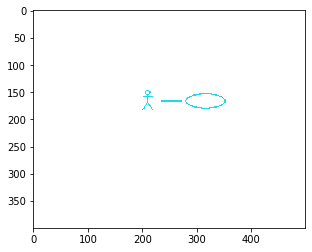

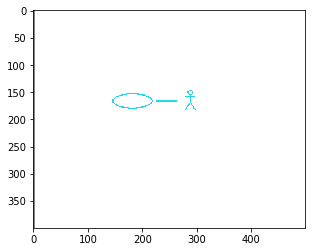

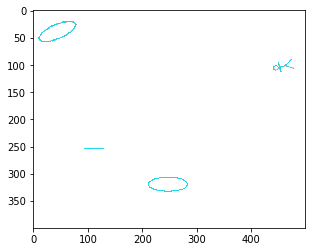

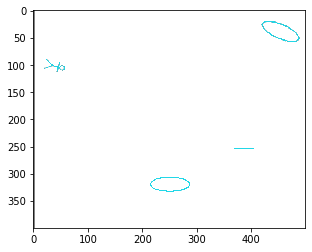

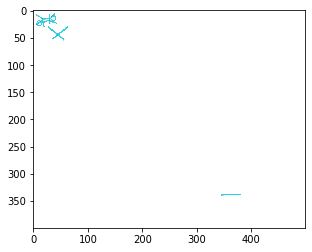

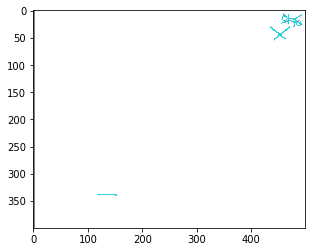

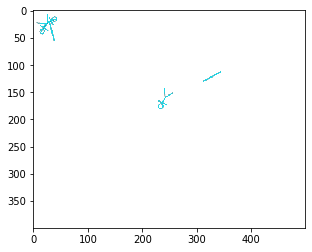

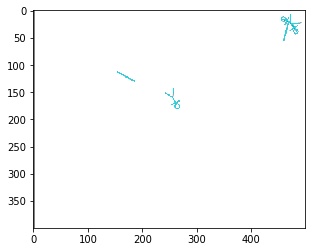

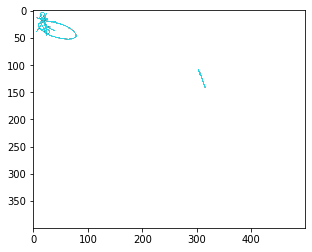

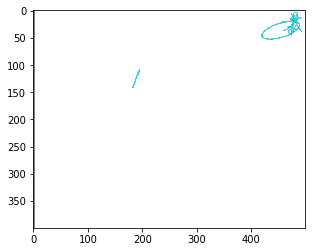

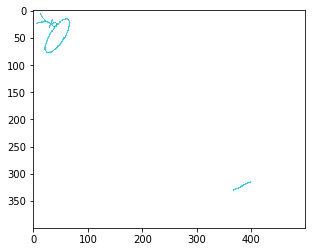

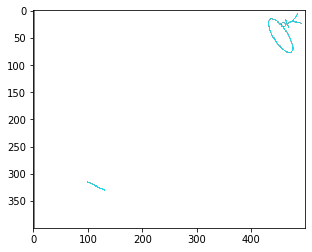

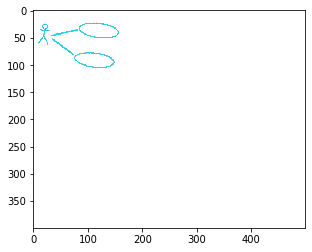

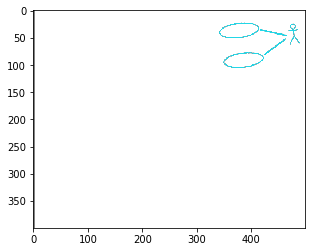

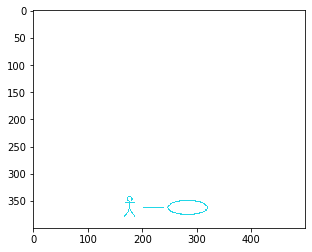

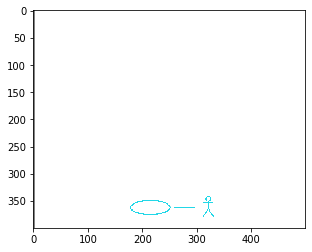

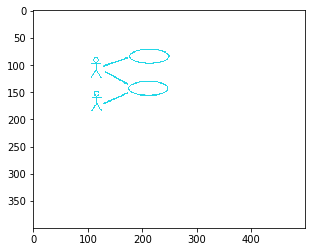

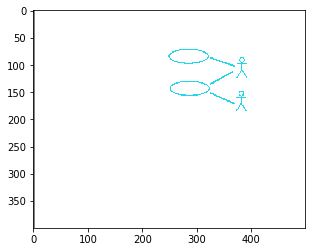

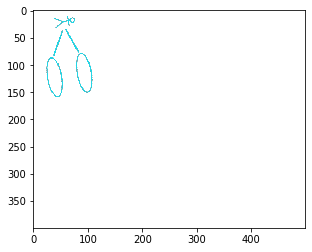

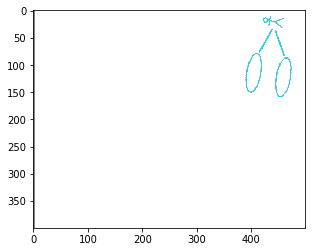

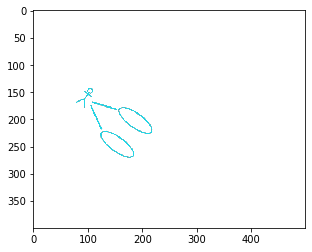

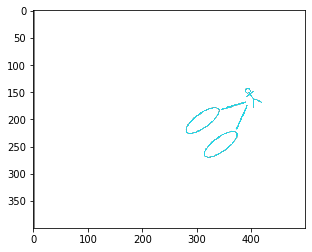

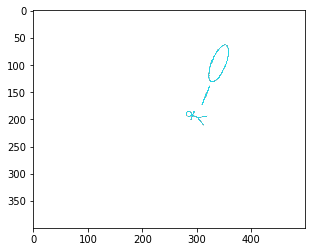

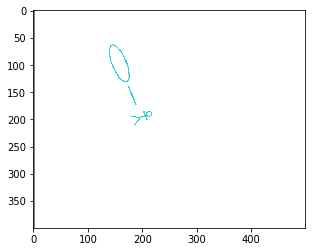

All images to array!
Train set size: 60, Val set size: 20, Test set size: 20


In [140]:
trainX, trainY, testX, testY = load_dataset('C:\images', 'C:\labeled.txt')

In [156]:
# run the test harness for evaluating a model
def run_test_harness(trainX, trainY, testX, testY):
    print('iniciating the load of the dataset')
    # load dataset
#     trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    print('iniciating the  preparation of pixel data')
#     trainX, testX = prep_pixels(trainX, testX)
    # evaluate model
    print('iniciating theevaluation of the model')
    scores, histories = evaluate_model(trainX, trainY)
    # learning curves
    print('iniciating the diagnostics')
    summarize_diagnostics(histories)
    # summarize estimated performance
    print('iniciating the diagnostic of performance')
    summarize_performance(scores)
    # define model
    print('iniciating definition of the model')
    model = define_model()
    model.summary()
    # fit model
    print('iniciating the fit of the model')
    model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0)
    # save model
    print('saving the model')
    model.save('final_model.h5')

In [159]:
# entry point, run the test harness
run_test_harness(trainX, trainY, testX, testY)

iniciating the load of the dataset
iniciating the  preparation of pixel data
iniciating theevaluation of the model
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


ValueError: Error when checking target: expected dense_2 to have shape (2,) but got array with shape (1,)

In [66]:
def run_example():
    # load model
    model = load_model('final_model.h5')
# load the images
    img = load_image('0.png')
    # predict the class
    digit = model.predict(img)
    print(digit)
def load_image(filename):
# load the image
    img = load_img(filename, grayscale=False, target_size=(800, 1000))
# convert to array
    img = img_to_array(img)
# reshape into a single sample with 1 channel
    img = img.reshape(-1, 3,400,500)
# prepare pixel data
    img = img.astype('float32')
    img = img / 255.0
    return img

In [47]:
# trainX2, trainY2, testX2, testY2 = load_dataset('C:\carpetaInutil', 'C:\etiquetadoMal.txt')

In [67]:
# entry point, run the example
run_example()

[[0.51675373]
 [0.51675373]
 [0.51675373]
 [0.51675373]]
